# Functional prior

Minimal Jax implementation of [All You Need is a Good Functional Prior for Bayesian Deep Learning](https://arxiv.org/abs/2011.12829) by Tran, et.al.

In [27]:
import jax
import chex
import optax
import gpjax as gpx
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from typing import Callable
from jaxtyping import Array
from jax.flatten_util import ravel_pytree

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
key = jax.random.PRNGKey(314)
key_gp, key_bnn, key_1l = jax.random.split(key, 3)

## GP prior

In [4]:
meanf = gpx.mean_functions.Zero()
kernel = gpx.kernels.RBF()

prior = gpx.Prior(mean_function=meanf, kernel=kernel)

In [5]:
n_samples = 20
xtest = jnp.linspace(-3, 3, 100)[:, None]
dist_prior = prior(xtest)

samples = dist_prior.sample(key_bnn, (n_samples,))

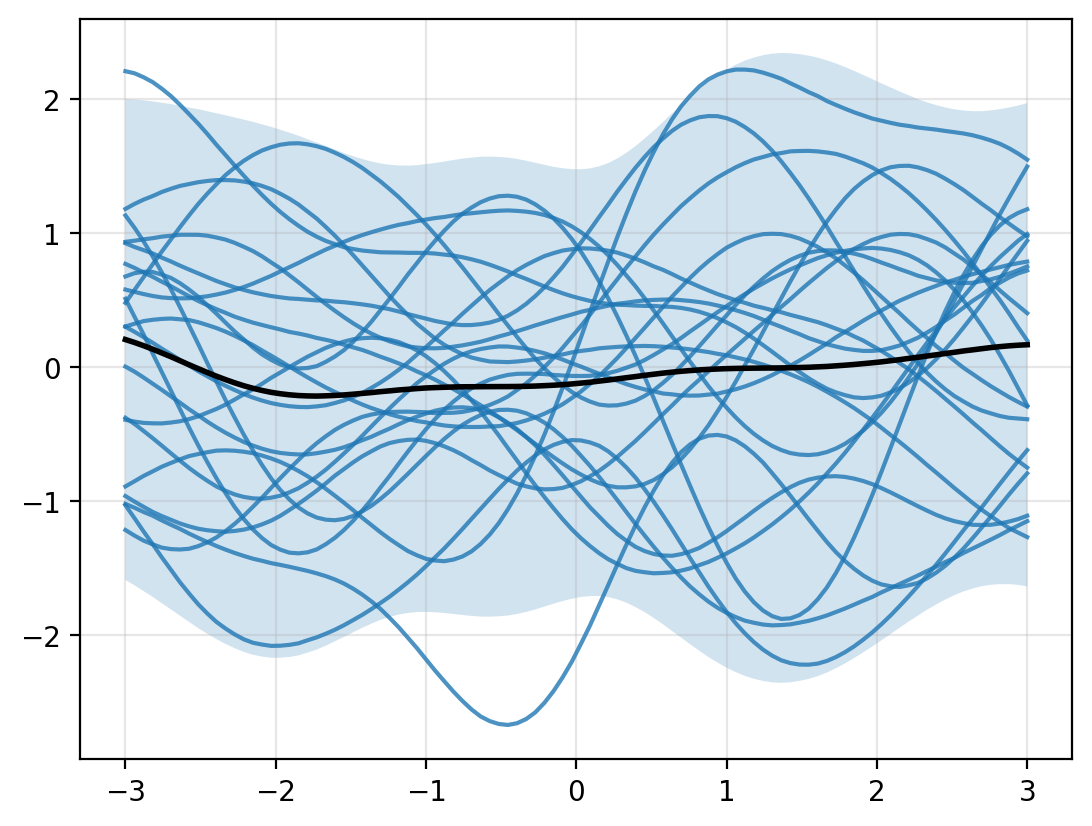

In [6]:
mean = samples.mean(axis=0)
std = samples.std(axis=0)

lbound = mean - 2 * std
ubound = mean + 2 * std

for sample in samples:
    plt.plot(xtest.ravel(), sample, c="tab:blue", alpha=0.8)
plt.grid(alpha=0.3)

plt.fill_between(xtest.ravel(), lbound, ubound, alpha=0.2)
plt.plot(xtest.ravel(), mean, c="black", linewidth=2)

## BNN MFVI prior

We start with $\theta_m \sim {\cal N}(0, 1)$ for all $m=1,\ldots, M$.

In [83]:
@chex.dataclass
class BBBParams:
    mean: Array
    logvar: Array

class BNN(nn.Module):
    n_out: int = 1
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
    def init(self, key, x, init_cov=1.0):
        keymean, keystd = jax.random.split(key)
        means = super().init(keymean, x)
        mflat, rfn = ravel_pytree(means)
        nparams = len(mflat)
        self.nparams = nparams
                        
        logvars = jax.random.normal(keystd, (nparams,)) + jnp.log(init_cov)
        logvars = rfn(logvars)
        
        bel = BBBParams(
            mean=means,
            logvar=logvars,
        )
        
        return bel
    
    def sample_state(self, key, bel, x):
        mean, rfn = ravel_pytree(bel.mean)
        logvar, _ = ravel_pytree(bel.logvar)
        std = jnp.exp(logvar / 2)
        
        sample = jax.random.normal(key, (self.nparams,)) * std + mean
        sample = rfn(sample)
        
        return sample

    def sample_states(self, key, bel, x, n_samples):
        keys = jax.random.split(key, n_samples)
        vmap_sample = jax.vmap(self.sample_state, (0, None, None))
        return vmap_sample(keys, bel, x)
    
    
    def _sample_pp_single(self, key, bel, x):
        params = self.sample_state(key, bel, x)
        yhat = self.apply(params, x)
        return yhat
    
    def sample_pp(self, key, bel, x, n_samples=None):
        if n_samples is None:
            yhat = self._sample_pp_single(key, bel, x)
            return yhat.squeeze()
        
        keys = jax.random.split(key, n_samples)
        sample_multiple = jax.vmap(self._sample_pp_single, (0, None, None))
        yhat_multiple = sample_multiple(keys, bel, x).squeeze()
        return yhat_multiple

In [84]:
bnn = BNN()
bel = bnn.init(key, xtest, init_cov=0.05)

In [85]:
samples = bnn.sample_pp(key_bnn, bel, xtest, n_samples)

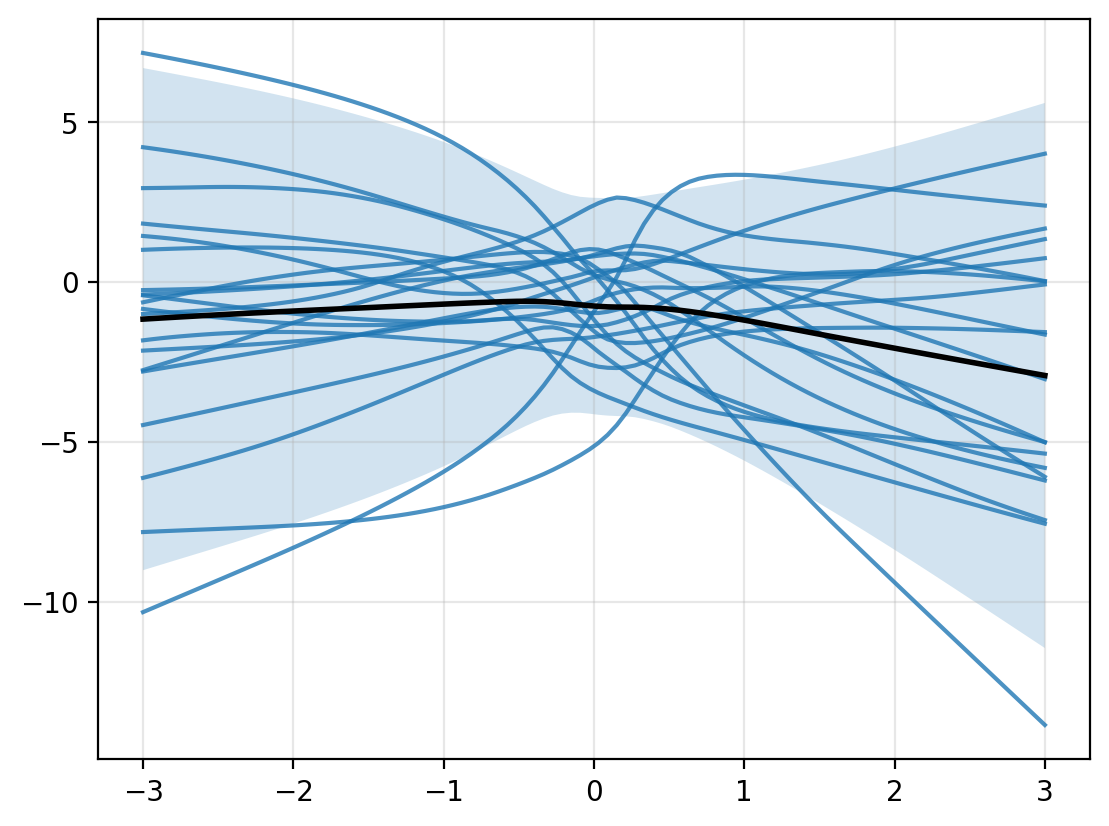

In [86]:
mean = samples.mean(axis=0)
std = samples.std(axis=0)

lbound = mean - 2 * std
ubound = mean + 2 * std

for sample in samples:
    plt.plot(xtest.ravel(), sample, c="tab:blue", alpha=0.8)
plt.grid(alpha=0.3)

plt.fill_between(xtest.ravel(), lbound, ubound, alpha=0.2)
plt.plot(xtest.ravel(), mean, c="black", linewidth=2)

# Wassertein Distance Optimisation

$$
    \min_\psi\max_\theta
    \mathbb{E}_{q}\left[
        \mathbb{E}_{p-\texttt{gp}}[\phi_{\boldsymbol\theta}(\text{f}_{\cal M})] -
        \mathbb{E}_{p-\texttt{nn}}[\phi_{\boldsymbol\theta}(\text{f}_{\cal M})]
    \right],
$$

where we define

$$
    {\cal L}(\psi, \theta) =
        \mathbb{E}_{p-\texttt{gp}}[\phi_{\boldsymbol\theta}(\text{f}_{\cal M})] -
        \mathbb{E}_{p-\texttt{nn}}[\phi_{\boldsymbol\theta}(\text{f}_{\cal M})]
$$,

* $\text{f}_\phi$ is a set of random variables from a **measurement set** ${\bf X}_{\cal M}$
* $\phi_\theta$ is a 1-Lipshitz function defined as an MLP with two hidden layers each, 200 units, and softplus activation function.

In [87]:
class Lip1(nn.Module):
    """
     1-Lipschitz function
    """
    n_out: int = 1
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(200)(x)
        x = nn.softplus(x)
        x = nn.Dense(200)(x)
        x = nn.softplus(x)
        x = nn.Dense(self.n_out)(x)
        return x.squeeze()

In [88]:
model_l1 = Lip1()
lparams = model_l1.init(key_1l, xtest)

## The measurement set

We want to obtain a GP-like prior in the range $[-3, 3]$.

In [89]:
n_lipschitz = 30

In [90]:
n_points = 100

In [91]:
# Sampled measurement set
Xm = jax.random.uniform(key, minval=-3, maxval=3, shape=(n_points,))

Computing

$$
    \mathbb{E}_{p\texttt{gp}}[\phi_\theta({\text f}_{\cal M})]
$$

In [92]:
dist_prior = prior(Xm)
samples_gp = dist_prior.sample(key_bnn, (n_samples,))
samples_gp.shape

(20, 100)

In [93]:
l1_gp = model_l1.apply(lparams, samples_gp[..., None])
l1_gp = l1_gp.mean(axis=0)
l1_gp.shape

(100,)

In [94]:
def compute_expected_l1_gp(key, params, X, n_samples):
    dist_prior = prior(X)
    samples_gp = dist_prior.sample(key, (n_samples,))
    # Lipshitz-1 transformation
    l1 = model_l1.apply(params, samples_gp[..., None ]).mean(axis=0)
    return l1

Computing

$$
    \mathbb{E}_{p\texttt{nn}}[\phi_\theta({\text f}_{\cal M})]
$$

In [95]:
samples_bnn = bnn.sample_pp(key_bnn, bel, Xm[:, None],  n_samples)
samples_bnn.shape

(20, 100)

In [96]:
l1_bnn = model_l1.apply(lparams, samples_bnn[..., None],)
l1_bnn.shape

(20, 100)

In [97]:
l1_bnn = model_l1.apply(lparams, samples_bnn[..., None])
l1_bnn = l1_bnn.mean(axis=0)
l1_bnn.shape

(100,)

In [98]:
def compute_expected_l1_bnn(key, params, bel, X, n_samples):
    samples_bnn = bnn.sample_pp(key, bel, X[:, None], n_samples)
    # Lipschitz-1 transformation
    l1 = model_l1.apply(params, samples_bnn[..., None]).mean(axis=0)
    return l1

## The regularisation term

In [463]:
def build_fhat(key, bel_bnn, Xm):
    key_eps, key_gp, key_bnn = jax.random.split(key, 3)
    eps = jax.random.uniform(key_eps)
    
    dist_prior = prior(Xm)
    samples_gp = dist_prior.sample(key_gp, (1,)).squeeze()
    
    samples_bnn = bnn.sample_pp(key_bnn, bel_bnn, Xm[:, None])
    
    fhat = samples_bnn * eps + (1 - eps) * samples_gp
    return fhat


@partial(jax.vmap, in_axes=(None, None, 0))
def gradient_fhat(model_l1, phi, f):
    lgrad = jax.grad(model_l1.apply, 1)
    return lgrad(phi, f[..., None]).squeeze()

In [464]:
@partial(jax.vmap, in_axes=(0, None, None, None, None))
def gradient_penalty(key, phi, bel_bnn, Xm, model_l1):
    fhat = build_fhat(key, bel_bnn, Xm)
    fgrads = gradient_fhat(model_l1, phi, fhat)
    return (jnp.linalg.norm(fgrads) - 1) ** 2

## The loss function

$$
    \mathcal{L}_R(\boldsymbol\psi, \boldsymbol\theta) = 
    \mathcal{L}(\boldsymbol\psi, \boldsymbol\theta) +
    \lambda\mathbb{E}_{p_\hat{f}}
    \left[\left(\big\vert\big\vert\nabla_{\hat f}\phi({\hat f})\big\vert\big\vert_2 - 1\right)^2\right]
$$

In [467]:
import optax
from flax.training.train_state import TrainState

In [537]:
n_samples = 50
n_points = 50
lmbda = 1.0

def distance_fn(bel_bnn, params_l1, key, X):
    key_bnn, key_gp = jax.random.split(key)
    l1_gp_samples = compute_expected_l1_gp(key_gp, params_l1, X, n_samples)
    l1_bnn_samples = compute_expected_l1_bnn(key_bnn, params_l1, bel_bnn, X, n_samples)
    L = (l1_gp_samples - l1_bnn_samples).mean()
    return L
    

def loss_fn(bel_bnn, params_l1, key, X):
    key, key_reg = jax.random.split(key)
    keys_reg = jax.random.split(key_reg, n_samples)
    
    L = distance_fn(bel_bnn, params_l1, key, X)
    reg = gradient_penalty(keys_reg, params_l1, bel_bnn, X, model_l1).mean()
    
    loss_reg = L + lmbda * reg
    return loss_reg

grad_l1 = jax.grad(loss_fn, 1)
grad_bnn = jax.value_and_grad(distance_fn, 0)

In [538]:
params_l1_init = model_l1.init(key_1l, xtest)
bel_bnn_init = bnn.init(key, xtest, init_cov=0.1)

state_l1 = TrainState.create(
    apply_fn=model_l1.apply,
    params=params_l1_init,
    tx=optax.adam(1e-5)
)


state_bnn = TrainState.create(
    apply_fn=bnn.apply,
    params=bel_bnn_init,
    tx=optax.adam(-1e-2)
)

In [539]:
grads = grad_l1(bel_bnn_init, params_l1_init, key, Xm)
state_l1.apply_gradients(grads=grads);

loss, grads = grad_bnn(bel_bnn_init, params_l1_init, key, Xm)

In [540]:
n_lipschitz = 40
@jax.jit
def update_step(keyt, state_bnn, state_l1):
    key_x, key_l1, key_bnn = jax.random.split(keyt, 3)
    X = jax.random.uniform(key_x, minval=-3, maxval=3, shape=(n_points,))
    
    def _inner_l1(t, state_l1):
        key = jax.random.fold_in(key_l1, t)
        grads = grad_l1(state_bnn.params, state_l1.params, key, X)
        state_l1 = state_l1.apply_gradients(grads=grads)
        return state_l1

    state_l1 = jax.lax.fori_loop(0, n_lipschitz, _inner_l1, state_l1)

    loss, grads = grad_bnn(state_bnn.params, state_l1.params, key_bnn, X)
    state_bnn = state_bnn.apply_gradients(grads=grads)
    return state_l1, state_bnn, loss

In [ ]:
losses = []

for e in (pbar := tqdm(range(100))):
    keyt = jax.random.fold_in(key, e)
    state_l1, state_bnn, loss = update_step(keyt, state_bnn, state_l1)
    losses.append(loss.item())
    pbar.set_description(f"{loss=:0.6f}")

In [542]:
samples_cold = bnn.sample_pp(key_bnn, bel_bnn_init, xtest, n_samples)
samples_warm = bnn.sample_pp(key_bnn, state_bnn.params, xtest, n_samples)

In [543]:
samples = samples_cold

In [544]:
ravel_pytree(state_bnn.params.logvar)[0]

Array([ 0.12913689, -3.5650523 , -2.2892847 , ..., -2.1897542 ,
       -3.899112  , -2.1458216 ], dtype=float32)

In [545]:
ravel_pytree(bel_bnn_init.logvar)[0]

Array([ 0.4803183, -3.3563743, -2.3132303, ..., -1.6614449, -3.398523 ,
       -1.6240593], dtype=float32)

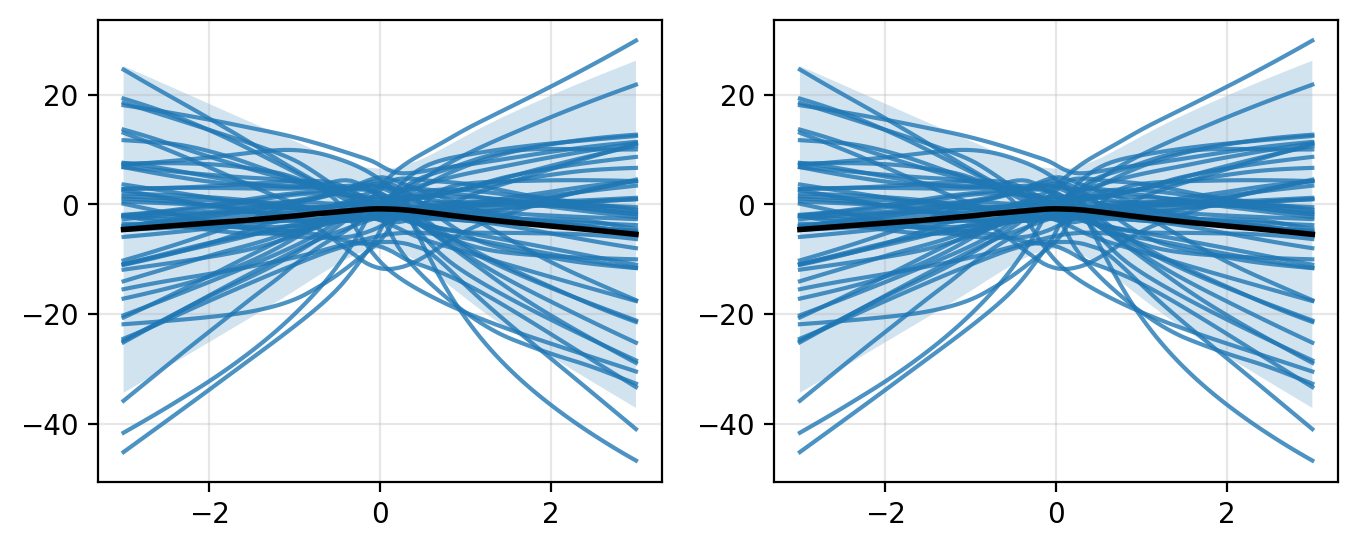

In [546]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for ax, sample in zip(axs, [samples_cold, samples_warm]):
    mean = samples.mean(axis=0)
    std = samples.std(axis=0)

    lbound = mean - 2 * std
    ubound = mean + 2 * std

    for sample in samples:
        ax.plot(xtest.ravel(), sample, c="tab:blue", alpha=0.8)
    ax.grid(alpha=0.3)

    ax.fill_between(xtest.ravel(), lbound, ubound, alpha=0.2)
    ax.plot(xtest.ravel(), mean, c="black", linewidth=2)